# CNN - CIFAR-10 이미지 분류 (다항분류)

## #01. 패키지 참조

In [ ]:
import os
import helper
import zipfile

from PIL import Image
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix

## #02. 데이터셋 준비하기

이미지에 대한 압축 파일을 구글 드라이브에 업로드 해 놓은 상황

### 1. 이미지 파일의 압축 해제

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 압축파일의 경로
file_path = "/content/drive/MyDrive/Colab Notebooks/CIFAR-10.zip"

# 압축을 해제할 경로
extract_dir = os.path.join(os.getcwd(), "data")

# 해당 폴더가 없다면 폴더를 생성
if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)

# 파일의 압축 해제
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(extract_dir)
zip_ref.close()

### 2. 임의의 이미지 확인

훈련용 이미지와 검증용 이미지가 따로 구분되어 있지 않다.

#### 각 폴더안에서 임의의 이미지를 추출하여 확인

In [ ]:
# 압축 해제된 폴더 경로
base_dir = os.path.join(extract_dir, "CIFAR-10")
print(base_dir)

# 훈련용 이미지 폴더
train_dir = os.path.join(base_dir, "train")
print(train_dir)

# 검증용 이미지 폴더
test_dir = os.path.join(base_dir, "test")
print(test_dir)

# 분류해야할 항목의 종류 --> 폴더의 종류
features = os.listdir(train_dir)
print(features)

/content/data/CIFAR-10
/content/data/CIFAR-10/train
/content/data/CIFAR-10/test
['deer', 'automobile', 'airplane', 'truck', 'ship', 'frog', 'horse', 'dog', 'cat', 'bird']


/content/data/CIFAR-10/train/deer


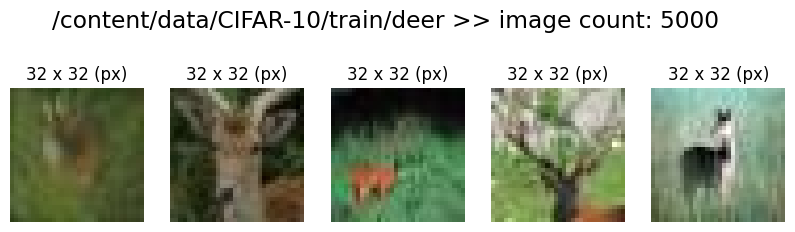

/content/data/CIFAR-10/train/automobile


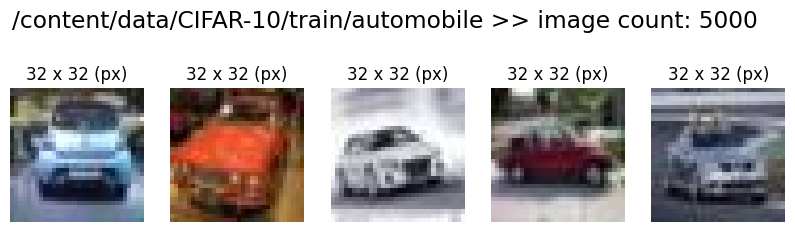

/content/data/CIFAR-10/train/airplane


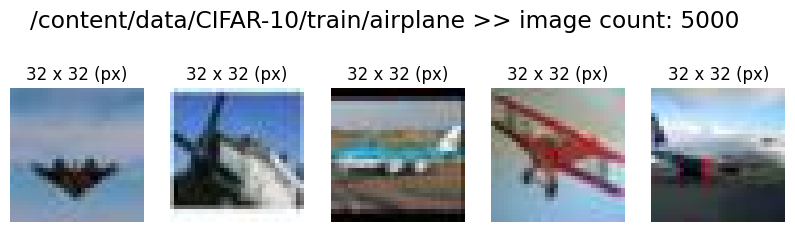

/content/data/CIFAR-10/train/truck


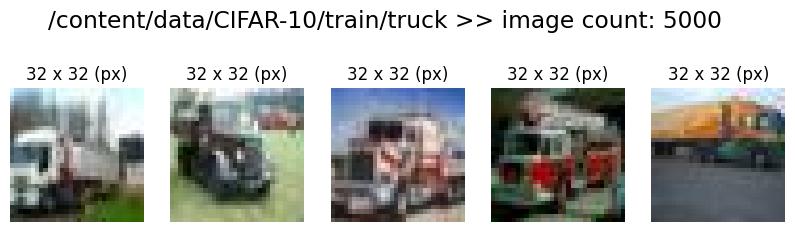

/content/data/CIFAR-10/train/ship


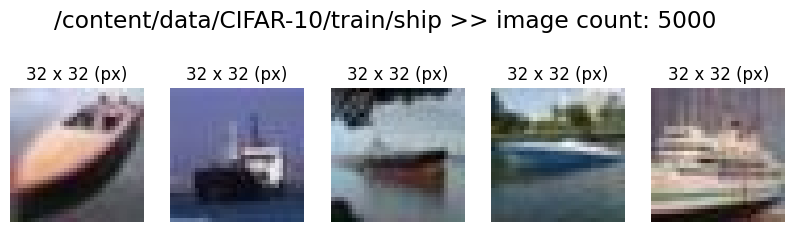

/content/data/CIFAR-10/train/frog


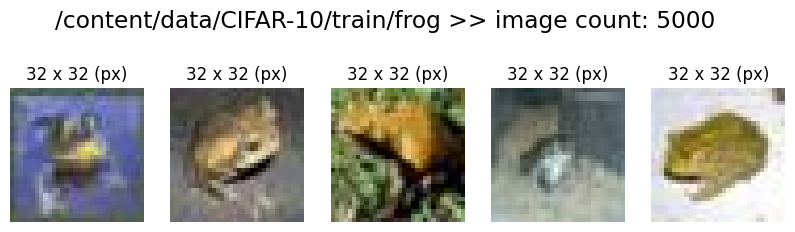

/content/data/CIFAR-10/train/horse


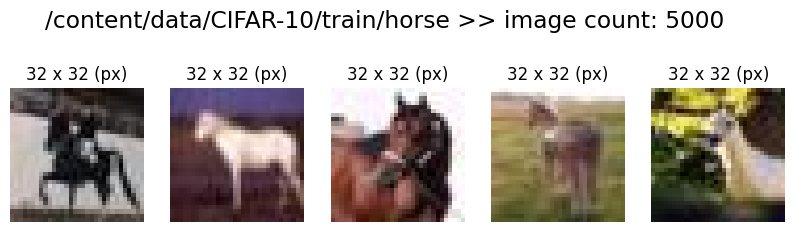

/content/data/CIFAR-10/train/dog


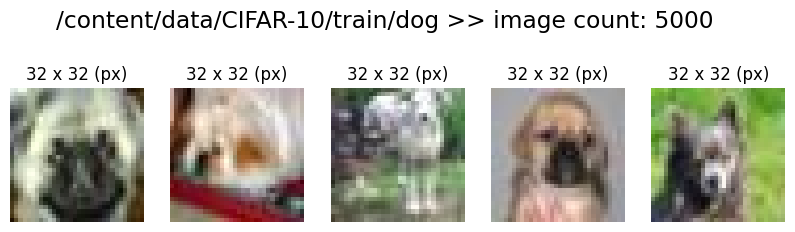

/content/data/CIFAR-10/train/cat


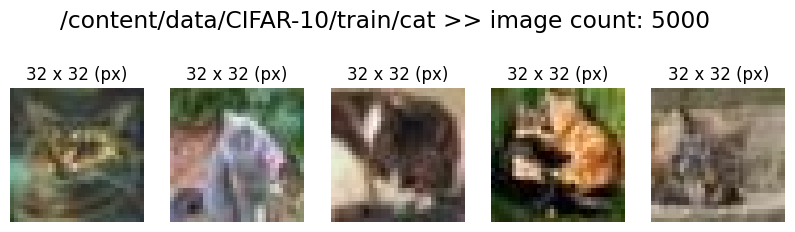

/content/data/CIFAR-10/train/bird


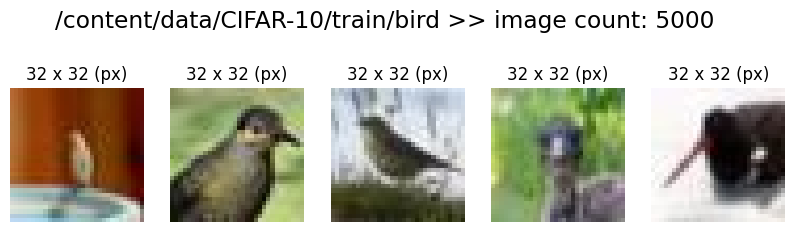

In [ ]:
for j, w in enumerate(features):
    # 각 폴더 경로
    target_dir = os.path.join(train_dir, w)
    print(target_dir)

    # 각 폴더별로 파일의 목록을 가져옴
    file_list = os.listdir(target_dir)

    # 각 폴더별 파일의 수
    file_count = len(file_list)

    fig, ax = plt.subplots(1, 5, figsize=(10, 3))
    fig.suptitle("%s >> image count: %d" % (target_dir, file_count))

    for k, x in enumerate(ax):
        file_path = os.path.join(target_dir, file_list[k])
        sample = Image.open(file_path)
        x.set_title("%d x %d (px)" % (sample.size[0], sample.size[1]), fontsize=12)
        x.imshow(sample)
        x.axis('off')

    plt.show()
    plt.close()

## #03. 데이터 전처리

### 이미지 데이터 증강

In [ ]:
train_datagen = ImageDataGenerator( rescale = 1.0/255 )
test_datagen = ImageDataGenerator( rescale = 1.0/255 )

train_set = train_datagen.flow_from_directory(train_dir, classes=features,
                                              batch_size=5, class_mode='categorical',
                                              target_size=(32, 32))

test_set = test_datagen.flow_from_directory(test_dir, classes=features,
                                             batch_size=5, class_mode='categorical',
                                             target_size=(32, 32))

len(train_set), len(test_set)

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


(10000, 2000)

## #03. 모델 개발

### 모델 정의

In [ ]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        208       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 16, 16, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        8224      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 32)        1

### 학습하기

In [ ]:
start = dt.datetime.now()

result = model.fit(train_set, epochs=500, validation_data=test_set, callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

end = dt.datetime.now()

delta = end - start

"총 학습 소요 시간: %d(초)" % delta.seconds

Epoch 1/500
10000/10000 [==============================] - 69s 6ms/step - loss: 1.6471 - acc: 0.4081 - val_loss: 1.4596 - val_acc: 0.4828 - lr: 0.0010
Epoch 2/500
10000/10000 [==============================] - 65s 7ms/step - loss: 1.3618 - acc: 0.5113 - val_loss: 1.4025 - val_acc: 0.5183 - lr: 0.0010
Epoch 3/500
10000/10000 [==============================] - 65s 6ms/step - loss: 1.2438 - acc: 0.5557 - val_loss: 1.1955 - val_acc: 0.5916 - lr: 0.0010
Epoch 4/500
10000/10000 [==============================] - 66s 7ms/step - loss: 1.1746 - acc: 0.5817 - val_loss: 1.0641 - val_acc: 0.6257 - lr: 0.0010
Epoch 5/500
10000/10000 [==============================] - 65s 7ms/step - loss: 1.1194 - acc: 0.6007 - val_loss: 1.0962 - val_acc: 0.6269 - lr: 0.0010
Epoch 6/500
10000/10000 [==============================] - 64s 6ms/step - loss: 1.0757 - acc: 0.6197 - val_loss: 0.9067 - val_acc: 0.6796 - lr: 0.0010
Epoch 7/500
10000/10000 [==============================] - 64s 6ms/step - loss: 1.0481 - acc: 

'총 학습 소요 시간: 1236(초)'

## #04. 학습 결과 평가

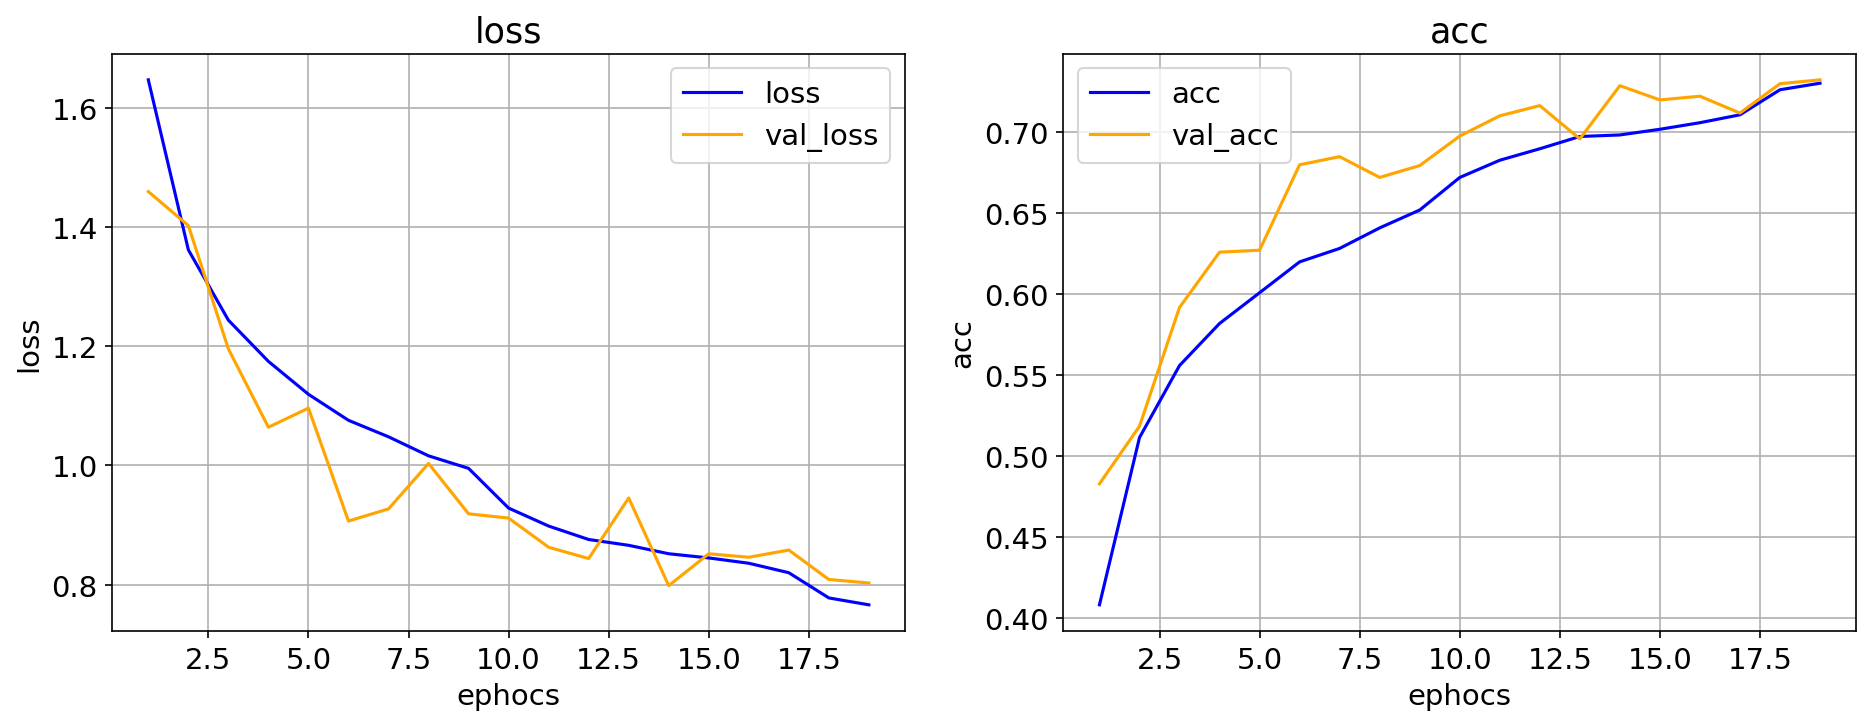

10000/10000 [==============================] - 35s 3ms/step - loss: 0.5340 - acc: 0.8135
최종 훈련 손실률: 0.534024, 최종 훈련 정확도: 0.813500
2000/2000 [==============================] - 7s 3ms/step - loss: 0.8027 - acc: 0.7320
최종 검증 손실률: 0.802739, 최종 검증 정확도: 0.732000


In [ ]:
helper.tf_result_plot(result)

evaluate1 = model.evaluate(train_set)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(test_set)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

## #05. 학습 결과 적용

### 훈련 데이터에 대한 예측 결과를 산정

In [ ]:
pred = model.predict(train_set)
data_count, case_count = pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
pred[0]

10000/10000 [==============================] - 33s 3ms/step
50000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([3.38686723e-03, 1.82808230e-06, 8.38023407e-05, 1.94098089e-08,
       1.13285125e-04, 9.39000189e-01, 4.49423760e-06, 1.23798920e-04,
       7.77719717e-04, 5.65079525e-02], dtype=float32)

### 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [ ]:
pred_result = np.argmax(pred, axis=-1)
pred_result

array([5, 8, 6, ..., 5, 5, 9])

### 각 종속변수별로 레이블링이 어떻게 되어 있는 확인

In [ ]:
class_names = list(train_set.class_indices.keys())
class_names

['deer',
 'automobile',
 'airplane',
 'truck',
 'ship',
 'frog',
 'horse',
 'dog',
 'cat',
 'bird']

In [ ]:
img, label = train_set[0]
label

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

### 훈련용 이미지에 대한 예측결과 확인

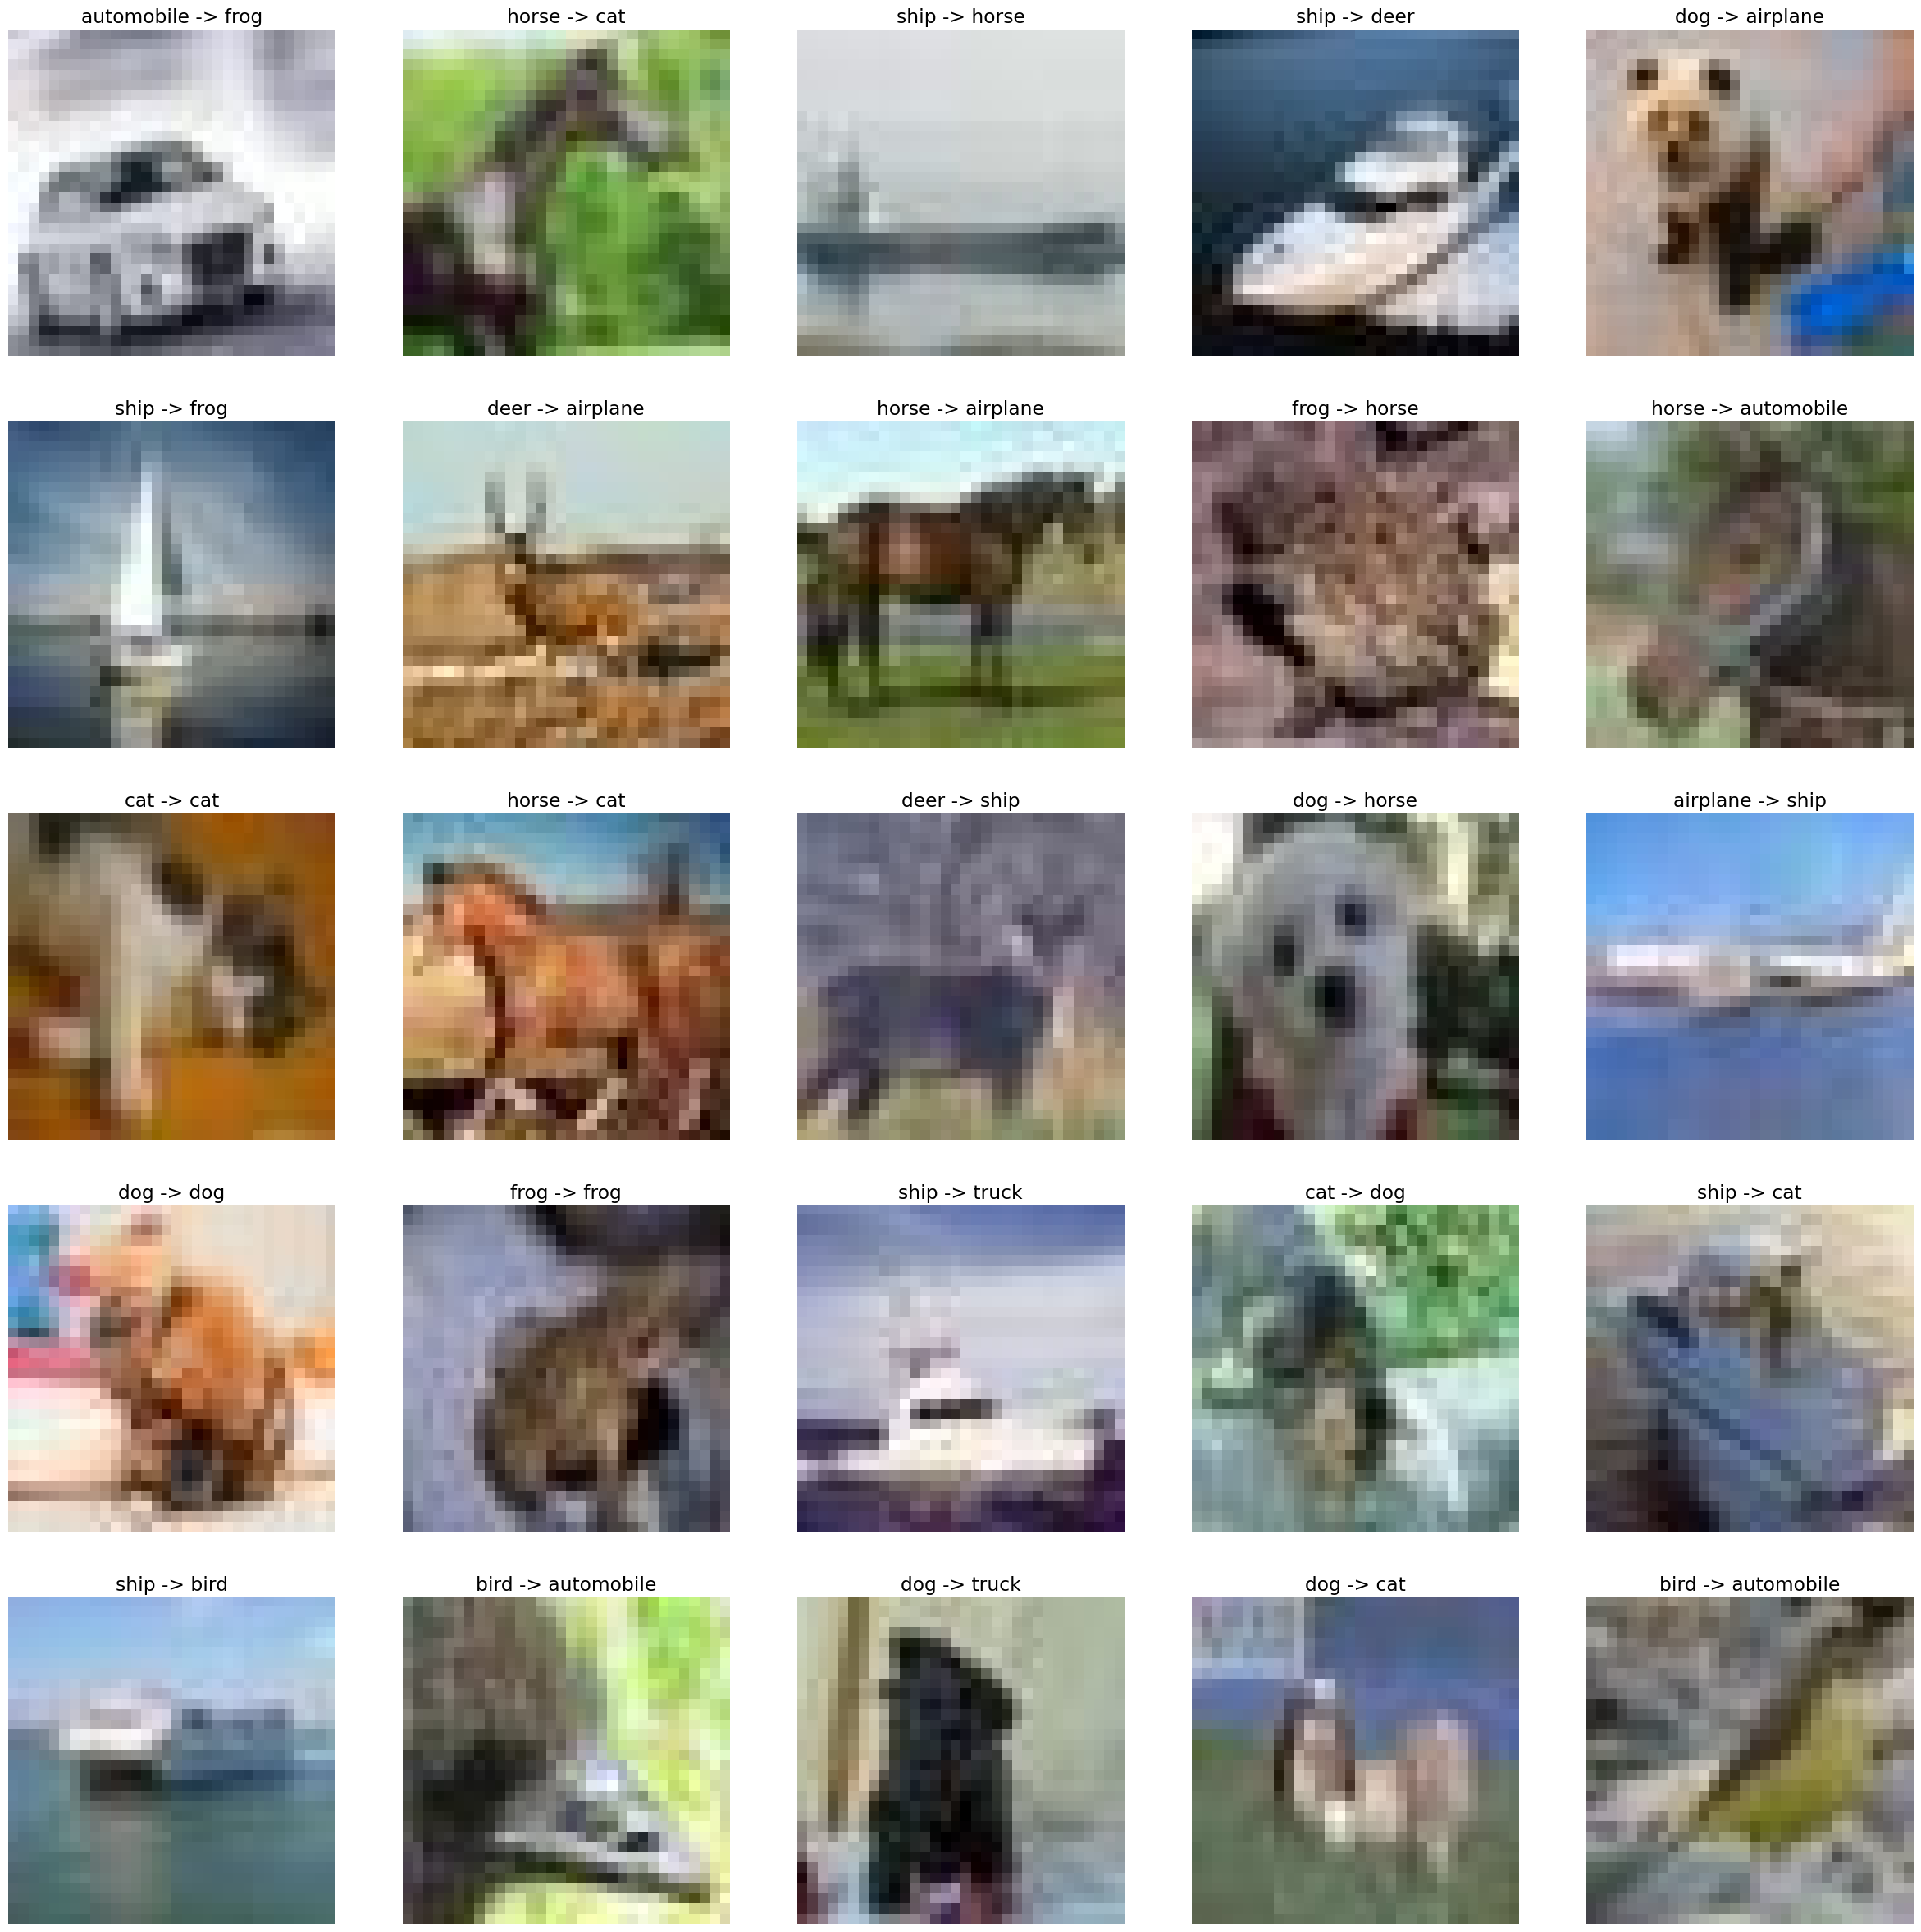

In [ ]:
row = 5                     # 내가 몇 줄을 출력하고 싶은지 지정
col = train_set.batch_size  # batch-size에 맞춰서 지정 (값이 너무 클 경우 반복문 로직을 따로 적용)
fig, ax = plt.subplots(row, col, figsize=((col+1)*5, (row+1)*5))

k = 0

for i in range(0, row):
    # batch_size 만큼의 첫 번째 이미지 묶음을 반환
    # -> img와 label의 길이는 col과 동일하다.
    img, label = train_set[i]

    for j in range(0, col):
        # 종속변수인 label은 one-hot-encoding 형태로 반환되므로 몇 번째 인덱스가 `1`인지 찾아야 한다.
        label_max = np.argmax(label[j], axis=-1)

        ax[i][j].imshow(img[j])
        ax[i][j].set_title("%s -> %s" % (class_names[label_max], class_names[pred_result[k]]))
        ax[i][j].axis('off')
        k += 1

plt.show()
plt.close()

### 혼동행렬

In [ ]:
train_set.labels

array([0, 0, 0, ..., 9, 9, 9], dtype=int32)

In [ ]:
cm = confusion_matrix(train_set.labels, pred_result)
cmdf2 = DataFrame(cm, columns=list(map(lambda x: "(r)%s" % class_names[x], range(10))), index=list(map(lambda x: "(p)%s" % class_names[x], range(10))))
cmdf2

,(r)deer,(r)automobile,(r)airplane,(r)truck,(r)ship,(r)frog,(r)horse,(r)dog,(r)cat,(r)bird
(p)deer,577,486,524,446,488,661,452,423,448,495
(p)automobile,575,467,492,473,541,665,479,392,459,457
(p)airplane,607,483,513,452,534,680,457,405,408,461
(p)truck,558,504,517,496,560,656,451,410,378,470
(p)ship,534,491,508,483,550,662,452,427,402,491
(p)frog,609,479,478,459,524,659,483,421,423,465
(p)horse,547,494,484,495,557,655,452,406,433,477
(p)dog,601,477,486,484,530,655,472,437,390,468
(p)cat,554,480,501,455,559,670,471,429,413,468
(p)bird,592,490,457,471,553,670,458,418,421,470


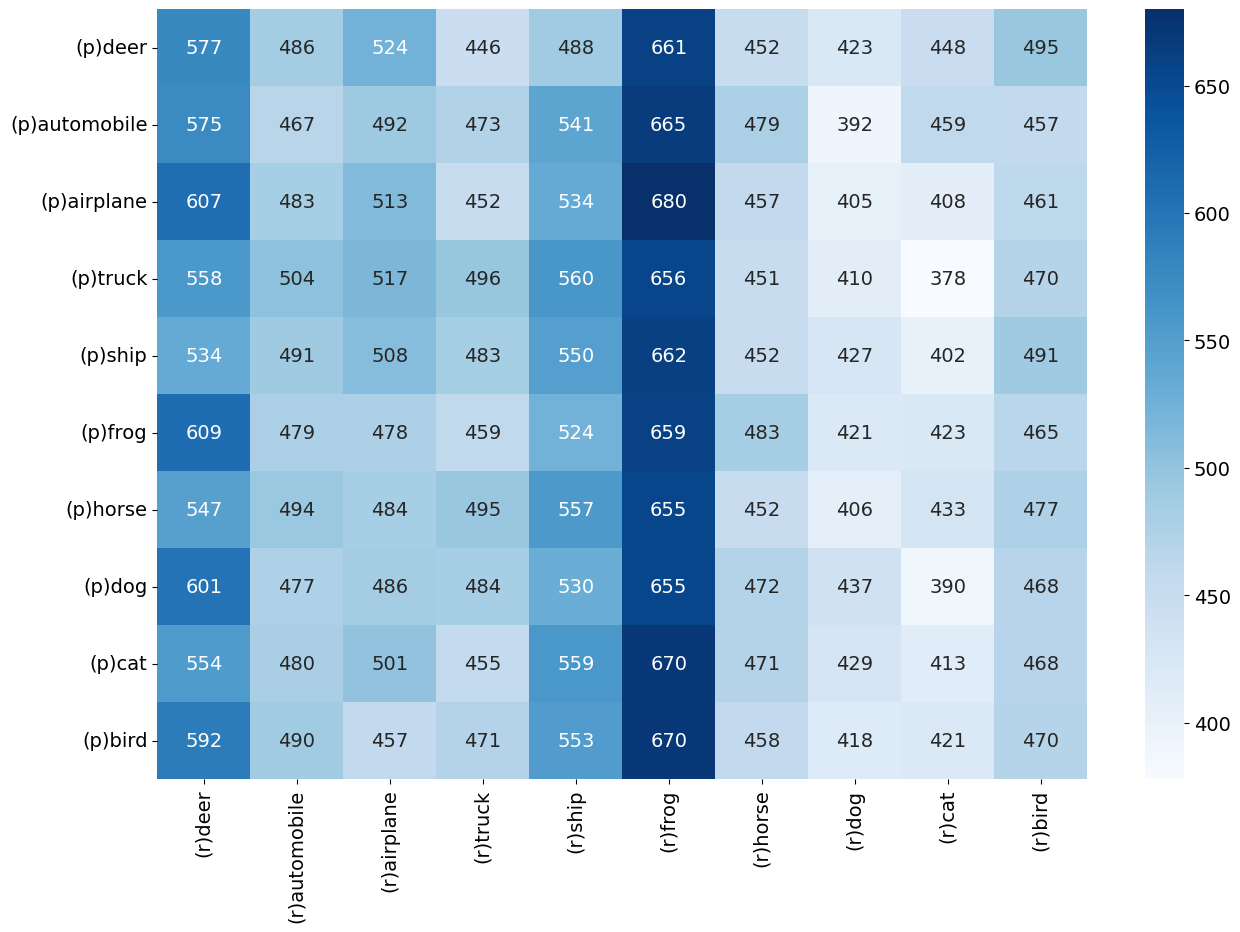

In [ ]:
plt.figure(figsize=(15, 10))
sb.heatmap(cmdf2, annot = True, fmt = 'd', cmap = 'Blues')
plt.show()
plt.close()